In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from util.file_util import StockTwitsFileReader, StockDataFileReader
from util.ts_util import (
    shift_date_index, calc_corr, 
    resample_weekly, rolling_nday)
from util.plot_util import (
    plot_time_series_bar, overlay_on_secondary_axis)
from util.stockdata_helper import (
    get_sp500_sector_info, get_gics_sector_list,
    get_etf_ticker_for_sector, get_component_tickers_for_sector,
    get_nday_returns_for_ticker
)
from config import STOCKTWITS_TICKER_LIST, ETF_TICKER_TO_SECTOR

In [4]:
start_date = '2016-01-01'
end_date = '2019-08-10'

twit_file_reader = StockTwitsFileReader() 
stock_file_reader = StockDataFileReader()

In [5]:
all_sectors = get_gics_sector_list()
all_sectors

['Consumer Staples',
 'Real Estate',
 'Industrials',
 'Information Technology',
 'Energy',
 'Materials',
 'Consumer Discretionary',
 'Financials',
 'Health Care',
 'Utilities',
 'All']

In [6]:
def append_sentiment_cols(sentiment_df):
    new_sentiment_df = sentiment_df.copy()
    
    new_sentiment_df['Bullish_minus_Bearish'] = new_sentiment_df['Bullish'] - new_sentiment_df['Bearish']
    new_sentiment_df['Log_Bullish_over_Bearish'] = np.log(new_sentiment_df['Bullish']) - np.log(new_sentiment_df['Bearish'])
    return new_sentiment_df

def get_daily_sentiment_agg_df_for_sector(sector):
    tickers_in_sector = get_component_tickers_for_sector(sector)
    print('number of component tickers {} in {}'.format(len(tickers_in_sector),
                                                        sector))
    
    daily_sentiment_agg_df = pd.DataFrame()

    for ticker in tickers_in_sector:
        twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker,
                                                                       start_date=start_date,
                                                                       end_date=end_date)

        daily_sentiment_agg_df = daily_sentiment_agg_df.add(twit_df, fill_value=0)
    
    return daily_sentiment_agg_df

In [7]:
sample_select_sector = 'All'

daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sample_select_sector)
wkly_sentiment_agg_df = resample_weekly(daily_sentiment_agg_df)

etf_ticker = get_etf_ticker_for_sector(sample_select_sector)

number of component tickers 502 in All


In [8]:
wkly_sentiment_agg_df.head()

,Bearish,Bullish
2016-01-01,30.0,85.0
2016-01-08,3996.0,6258.0
2016-01-15,3951.0,5533.0
2016-01-22,3820.0,5346.0
2016-01-29,4193.0,8870.0


In [9]:
etf_price_ts = stock_file_reader.read_stockdata_in_range(etf_ticker,
                                                         start_date,
                                                         end_date)

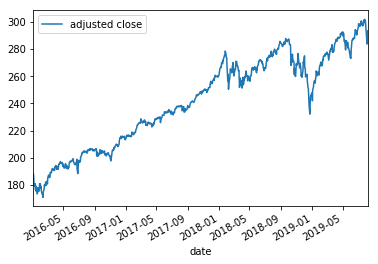

In [10]:
etf_price_ts.plot()

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


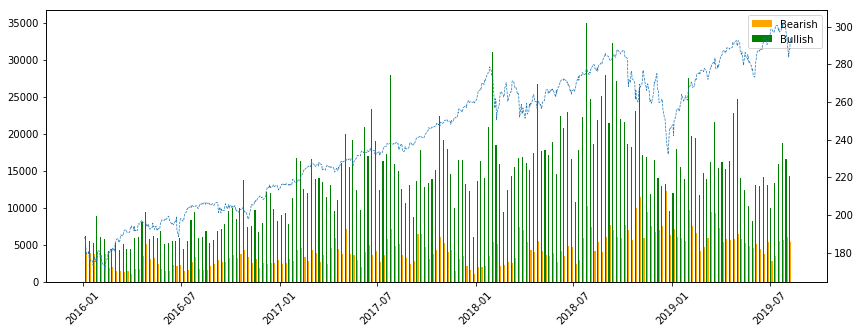

In [11]:
ax = plot_time_series_bar(wkly_sentiment_agg_df[['Bearish', 'Bullish']], 
                          figsize=(14, 5),)

overlay_on_secondary_axis(etf_price_ts, 'adjusted close', ax)

### Very rough eyeball - seems that 2017 is a good start

### Daily Correlations by Lag

In [12]:
start_date = '2017-01-01'
end_date = '2019-08-10'

In [13]:
sentiment_types = [
    'Bullish',
    'Bearish',
    'Bullish_minus_Bearish',
    'Log_Bullish_over_Bearish'
]

In [15]:
# lags indicate Twit leads
n_lags = [0, 1, 3, 5]
corr_summary = []


for sector in all_sectors:
    
    daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sector)
    etf_ticker = get_etf_ticker_for_sector(sector)
    daily_etf_return = get_nday_returns_for_ticker(etf_ticker, 
                                                   start_date, 
                                                   end_date,
                                                   n_days=1)
    
    daily_sentiment_agg_df = append_sentiment_cols(daily_sentiment_agg_df)
    
    for sentiment_type in sentiment_types:
        for lag in n_lags:
            if lag == 0:
                shifted_daily_sentiment_agg_df = daily_sentiment_agg_df
            else:
                shifted_daily_sentiment_agg_df = shift_date_index(daily_sentiment_agg_df, lag)

            corr = calc_corr(shifted_daily_sentiment_agg_df, 
                             daily_etf_return,
                             sentiment_type,
                             'adjusted close return')
            corr_summary.append({
                'ticker': etf_ticker,
                'sector': sector,
                'sentiment_type': sentiment_type,
                'lag': lag,
                'corr': corr,
            })

number of component tickers 33 in Consumer Staples


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 32 in Real Estate


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 69 in Industrials
number of component tickers 68 in Information Technology
number of component tickers 28 in Energy


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 27 in Materials


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 62 in Consumer Discretionary
number of component tickers 67 in Financials
number of component tickers 62 in Health Care
number of component tickers 28 in Utilities


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 502 in All


In [16]:
corr_summary_df = pd.DataFrame(corr_summary)

In [17]:
corr_summary_df_pivot = corr_summary_df.pivot_table(
    index=['sentiment_type', 'ticker', 'sector'],
    columns=['lag'],
    values='corr'
).round(2)

In [18]:
corr_summary_df_pivot.loc['Log_Bullish_over_Bearish']

,lag,0,1,3,5
ticker,sector,,,,
SPY,All,0.34,-0.02,-0.02,-0.03
XLB,Materials,0.21,0.02,-0.00,-0.07
XLE,Energy,0.37,0.05,0.02,-0.03
XLF,Financials,0.36,-0.01,0.00,-0.09
XLI,Industrials,0.25,0.00,-0.02,0.03
XLK,Information Technology,0.32,-0.05,-0.03,-0.05
XLP,Consumer Staples,0.26,0.01,-0.01,-0.03
XLRE,Real Estate,0.20,-0.01,0.01,0.00
XLU,Utilities,0.08,-0.01,0.01,0.01


### Daily vs. NDay Correlation

In [19]:
n_days = [1, 5, 21, 63, 128, 256]
corr_summary = []


for sector in all_sectors:
    
    daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sector)
    etf_ticker = get_etf_ticker_for_sector(sector)
    
    daily_sentiment_agg_df = append_sentiment_cols(daily_sentiment_agg_df)
    
    for sentiment_type in sentiment_types:
        
        for n_day in n_days:
            nday_etf_return = get_nday_returns_for_ticker(etf_ticker, 
                                                           start_date, 
                                                           end_date,
                                                           n_days=n_day)
            
            shifted_daily_sentiment_agg_df = shift_date_index(daily_sentiment_agg_df, 
                                                              n_day)

            corr = calc_corr(shifted_daily_sentiment_agg_df, 
                             nday_etf_return,
                             sentiment_type,
                             'adjusted close return')
            corr_summary.append({
                'ticker': etf_ticker,
                'sector': sector,
                'sentiment_type': sentiment_type,
                'nday': n_day,
                'corr': corr,
            })

number of component tickers 33 in Consumer Staples


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 32 in Real Estate


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 69 in Industrials
number of component tickers 68 in Information Technology
number of component tickers 28 in Energy


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 27 in Materials


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 62 in Consumer Discretionary
number of component tickers 67 in Financials
number of component tickers 62 in Health Care
number of component tickers 28 in Utilities


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 502 in All


In [20]:
corr_summary_df = pd.DataFrame(corr_summary)

In [21]:
corr_summary_df_pivot = corr_summary_df.pivot_table(
    index=['sentiment_type', 'ticker', 'sector'],
    columns=['nday'],
    values='corr'
).round(2)

In [22]:
corr_summary_df_pivot.loc['Log_Bullish_over_Bearish']

,nday,1,5,21,63,128,256
ticker,sector,,,,,,
SPY,All,-0.02,-0.07,-0.14,-0.26,-0.41,-0.43
XLB,Materials,0.02,-0.03,-0.02,-0.10,-0.23,-0.31
XLE,Energy,0.05,-0.01,0.03,0.09,0.03,-0.19
XLF,Financials,-0.01,-0.08,-0.14,-0.26,-0.39,-0.46
XLI,Industrials,0.00,0.00,0.03,-0.19,-0.26,-0.31
XLK,Information Technology,-0.05,-0.11,-0.16,-0.22,-0.38,-0.32
XLP,Consumer Staples,0.01,-0.03,-0.12,-0.20,-0.31,-0.17
XLRE,Real Estate,-0.01,0.03,0.03,-0.04,-0.06,0.13
XLU,Utilities,-0.01,0.03,-0.04,-0.12,-0.02,0.05


### Weekly vs NDay Correlation

In [23]:
from util.ts_util import rolling_nday

In [24]:
n_days = [1, 5, 21, 63, 128, 256]
corr_summary = []


for sector in all_sectors:

    daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sector)
    weekly_sentiment_agg_df = rolling_nday(daily_sentiment_agg_df, window='180D')
    etf_ticker = get_etf_ticker_for_sector(sector)
    
    weekly_sentiment_agg_df = append_sentiment_cols(weekly_sentiment_agg_df)
    
    for sentiment_type in sentiment_types:
        
        for n_day in n_days:
            nday_etf_return = get_nday_returns_for_ticker(etf_ticker, 
                                                           start_date, 
                                                           end_date,
                                                           n_days=n_day)
            
            shifted_weekly_sentiment_agg_df = shift_date_index(weekly_sentiment_agg_df, 
                                                               n_day)

            corr = calc_corr(shifted_weekly_sentiment_agg_df, 
                             nday_etf_return,
                             sentiment_type,
                             'adjusted close return')
            corr_summary.append({
                'ticker': etf_ticker,
                'sector': sector,
                'sentiment_type': sentiment_type,
                'nday': n_day,
                'corr': corr,
            })

number of component tickers 33 in Consumer Staples
number of component tickers 32 in Real Estate


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 69 in Industrials
number of component tickers 68 in Information Technology
number of component tickers 28 in Energy
number of component tickers 27 in Materials
number of component tickers 62 in Consumer Discretionary
number of component tickers 67 in Financials
number of component tickers 62 in Health Care
number of component tickers 28 in Utilities


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 502 in All


In [25]:
corr_summary_df = pd.DataFrame(corr_summary)

In [26]:
corr_summary_df_pivot = corr_summary_df.pivot_table(
    index=['sentiment_type', 'ticker', 'sector'],
    columns=['nday'],
    values='corr'
).round(2)

In [27]:
corr_summary_df_pivot.loc['Log_Bullish_over_Bearish']

,nday,1,5,21,63,128,256
ticker,sector,,,,,,
SPY,All,-0.04,-0.09,-0.21,-0.27,-0.60,-0.50
XLB,Materials,-0.04,-0.08,-0.22,-0.55,-0.82,-0.67
XLE,Energy,0.00,0.00,0.05,0.01,-0.21,-0.78
XLF,Financials,-0.06,-0.15,-0.32,-0.59,-0.85,-0.69
XLI,Industrials,-0.04,-0.08,-0.19,-0.34,-0.37,0.04
XLK,Information Technology,-0.03,-0.07,-0.19,-0.29,-0.65,-0.27
XLP,Consumer Staples,-0.06,-0.15,-0.33,-0.47,-0.23,0.16
XLRE,Real Estate,-0.04,-0.12,-0.21,-0.28,0.20,0.48
XLU,Utilities,-0.01,-0.02,-0.01,0.09,0.30,0.60


In [28]:
corr_summary_df_pivot.loc['Log_Bullish_over_Bearish'].median()

nday
1     -0.04
5     -0.08
21    -0.19
63    -0.28
128   -0.37
256   -0.27
dtype: float64

In [32]:
corr_summary = []


for sector in ['Industrials']:

    daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sector)
    weekly_sentiment_agg_df = resample_weekly(daily_sentiment_agg_df)
    etf_ticker = get_etf_ticker_for_sector(sector)
    
    weekly_sentiment_agg_df = append_sentiment_cols(weekly_sentiment_agg_df)
    
    for sentiment_type in sentiment_types:
        
        
        nday_etf_return = get_nday_returns_for_ticker(etf_ticker, 
                                                       start_date, 
                                                       end_date,
                                                       n_days=5)
        nday_etf_return = nday_etf_return.resample('W-FRI').last()

        shifted_weekly_sentiment_agg_df = weekly_sentiment_agg_df.shift(1)

        corr = calc_corr(shifted_weekly_sentiment_agg_df, 
                         nday_etf_return,
                         sentiment_type,
                         'adjusted close return')
        corr_summary.append({
            'ticker': etf_ticker,
            'sector': sector,
            'sentiment_type': sentiment_type,
#             'nday': n_day,
            'corr': corr,
        })

number of component tickers 69 in Industrials


In [33]:
daily_sentiment_agg_df.std()

Bearish    143.512039
Bullish    131.807032
dtype: float64

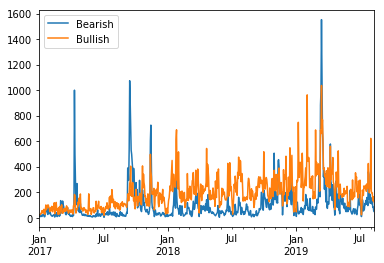

In [34]:
daily_sentiment_agg_df.plot()

In [ ]:
corr_summary_df = pd.DataFrame(corr_summary)

In [ ]:
corr_summary_df = corr_summary_df[corr_summary_df['sentiment_type'] == 'Log_Bullish_over_Bearish']

In [ ]:
corr_summary_df.drop('sentiment_type', axis=1).sort_values('corr').round(2)

In [ ]:
sector

In [ ]:
daily_sentiment_agg_df